# Ghasemi Visualization

In [1]:
using Plots
using Colors
using PyCall
@pyimport scipy.stats as scipystats

In [2]:
pyplot()

Plots.PyPlotBackend()

In [3]:
srand(0)
x = hcat(randn(1, 60), rand(1, 30) * 10 - 3, 5 + randn(1, 10))
y = vcat(zeros(Int, 90), ones(Int, 10));

In [4]:
multi_kde(x) = scipystats.gaussian_kde(x)[:pdf]

multi_kde (generic function with 1 method)

In [5]:
p_outlier = sum(y .== 1) / size(x, 2)
p_inlier = 1 - p_outlier;
p_x = scipystats.gaussian_kde(x)
p_x_inlier = scipystats.gaussian_kde(reshape(x[y .== 0], (1, length(x[y .== 0]))))
p_x_outlier = scipystats.gaussian_kde(reshape(x[y .== 1], (1, length(x[y .== 1]))));

---

## Probability strategies

The strategies proposed in the paper "Ghasemi, A. et al. Active Learning from Positive and Unlabeled Data."

In [6]:
τ_MM(x) = -abs.((2 * p_x_inlier(x) * p_inlier - p_x(x)) ./ p_x(x))
τ_EMM(x) = (p_x_inlier(x) ./ p_x(x) - 1) .* sign.(0.5 - p_x_inlier(x) ./ p_x(x))
function τ_EME(x)
    a = p_x_inlier(x) ./ p_x(x)
    valid_score(a) = (-a^2 * log(a) + a + (a - 1)^2 * log(1 - a)) / (2 * a)
    [(1 - s) <= 0 ? 0 : valid_score(s) for s in a]
end

τ_EME (generic function with 1 method)

In [7]:
pyplot(size = (450,250))

Plots.PyPlotBackend()

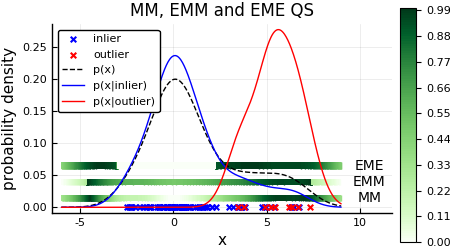

In [8]:
min_max_scale(x) = (x - minimum(x)) / (maximum(x) - minimum(x))
compute_scores(x, strategy, repeat=3) = min_max_scale(repmat(strategy(x)', repeat, 1))
x_plot = reshape(linspace(-6, 9, 500), 1, 500)
style = Dict(:color => colormap("Greens"), :levels => 100)
text_style = (:center, 10)
f = scatter(x[y .== 0], zeros(length(x[y .== 0])), label="inlier", color=:blue, marker=:x)
scatter!(x[y .== 1], zeros(length(x[y .== 1])), label="outlier", color=:red, marker=:x)
contourf!(x_plot[:], 0.01:0.005:0.02, compute_scores(x_plot, τ_MM), annotations=(10.5, 0.015, text("MM", text_style...)); style...)
contourf!(x_plot[:], 0.035:0.005:0.045, compute_scores(x_plot, τ_EMM), annotations=(10.5, 0.04, text("EMM", text_style...)); style...)
contourf!(x_plot[:], 0.06:0.005:0.07, compute_scores(x_plot, τ_EME), annotations=(10.5, 0.065, text("EME", text_style...)); style...)
plot!(x_plot[:], p_x[:pdf](x_plot), color=:black, label="p(x)", linestyle=:dash)
plot!(x_plot[:], p_x_inlier[:pdf](x_plot), color=:blue, label="p(x|inlier)", linestyle=:solid)
plot!(x_plot[:], p_x_outlier[:pdf](x_plot), color=:red, label="p(x|outlier)", linestyle=:solid)
xlims!(-6.5, 11.75)
title!("MM, EMM and EME QS", titlefont=font(12))
xlabel!("x")
ylabel!("probability density")
savefig(f, "../plots/plot_ghasemi_probability_densities.pdf")
f

---

## Robustness strategies

The strategies proposed in the paper "Ghasemi, A. et al. 2011. Active one-class learning by kernel density estimation. (2011)."

In [9]:
leave_out_one_cv_kde(x) = mean(multi_kde(x[1:end .!= i])(x[i]) for i in 1:length(x))[1]

leave_out_one_cv_kde (generic function with 1 method)

In [10]:
s_t_a(u) = leave_out_one_cv_kde(hcat(x[y .== 0]', u))
s_t_b(u) = mean(multi_kde(hcat(x[y .== 0]', u))(x[y .== 1]))
s_o_a(u) = leave_out_one_cv_kde(x[y .== 0]')
s_o_b(u) = mean(multi_kde(x[y .== 0]')(hcat(x[y .== 1]', u)))
s_t(u) = s_t_a(u) - s_t_b(u)
s_o(u) = s_o_a(u) - s_o_b(u)

s_o (generic function with 1 method)

In [11]:
x_plot = reshape(linspace(-6, 9, 100), 1, 100)
s_t_plot = [s_t_a(u) - s_t_b(u) for u in x_plot]
s_o_plot = [s_o_a(u) - s_o_b(u) for u in x_plot];

In [12]:
score_3 = multi_kde(x[y .== 0])(x_plot)' .* s_t_plot
score_4 = p_inlier * s_t_plot + p_outlier * s_o_plot;

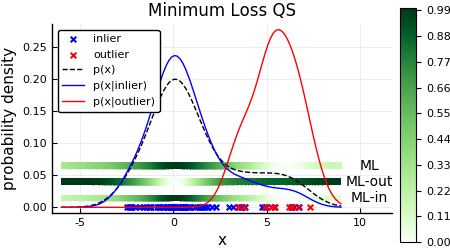

In [13]:
min_max_scale(x) = (x - minimum(x)) / (maximum(x) - minimum(x))
dup_scores(x, repeat=3) = min_max_scale(repmat(x, repeat, 1))
style = Dict(:color => colormap("Greens"), :levels => 100)
text_style = (:center, 10)
f = scatter(x[y .== 0], zeros(length(x[y .== 0])), label="inlier", color=:blue, marker=:x)
scatter!(x[y .== 1], zeros(length(x[y .== 1])), label="outlier", color=:red, marker=:x)
contourf!(x_plot[:], 0.01:0.005:0.02, dup_scores(s_t_plot), annotations=(10.5, 0.015, text("ML-in", text_style...)); style...)
contourf!(x_plot[:], 0.035:0.005:0.045, dup_scores(s_o_plot), annotations=(10.5, 0.04, text("ML-out", text_style...)); style...)
contourf!(x_plot[:], 0.06:0.005:0.07, dup_scores(score_4), annotations=(10.5, 0.065, text("ML", text_style...)); style...)
plot!(x_plot[:], p_x[:pdf](x_plot), color=:black, label="p(x)", linestyle=:dash)
plot!(x_plot[:], p_x_inlier[:pdf](x_plot), color=:blue, label="p(x|inlier)", linestyle=:solid)
plot!(x_plot[:], p_x_outlier[:pdf](x_plot), color=:red, label="p(x|outlier)", linestyle=:solid)
xlims!(-6.5, 11.75)
title!("Minimum Loss QS", titlefont=font(12))
xlabel!("x")
ylabel!("probability density")
savefig(f, "../plots/plot_minimum_loss_qs.pdf")
f